In [1]:
using Distributions, Plots, Optim, Statistics, Random, DataFrames, Interpolations

## Constants

In [2]:
σ = 1.5
β = 0.99322
eₕ = 1
eₗ = 0.1
πs = [0.925 0.075; 0.5 0.5]
a̲s = [-2, -4, -6, -8]
tol = 10^-2
Nₚ = 300
a_max = 8;

In [3]:
u(c) = c > 0. ? ((c) ^ (1 - σ)) / (1 - σ) : -Inf

u (generic function with 1 method)

## Functions

In [35]:
function VFI(u, Γ, tol, Nₚ, a_max, β, q, πs, eₕ, eₗ, a̲; print_dist = false)

    a_grid = range(a̲, a_max, length = Nₚ)
    Vₕ = [collect(a_grid)] #Value Function for Employment
    Vₗ = [collect(a_grid)] #Value Function for Unemployment
    dist = 1.
    Vh = zeros(Nₚ)
    Vl = zeros(Nₚ)
    aₕ_prime = zeros(Nₚ) #Policy Function for Employment
    aₗ_prime = zeros(Nₚ) #Policy Function for Unemployment


    while dist > tol
        V⁰ʰ = LinearInterpolation(a_grid, Vₕ[end], extrapolation_bc = Linear())
        V⁰ˡ = LinearInterpolation(a_grid, Vₗ[end], extrapolation_bc = Linear())
        for i ∈ 1:Nₚ
            πₕ = πs[1, :] 
            πₗ = πs[2, :]
            Tvₕ(a′) = -(u(a_grid[i] .+ eₕ .- a′*q) + β * (V⁰ʰ(a′) * πₕ[1] + V⁰ˡ(a′) * πₕ[2]))
            Tvₗ(a′) = -(u(a_grid[i] .+ eₗ .- a′*q) + β * (V⁰ʰ(a′) * πₗ[1] + V⁰ˡ(a′) * πₗ[2]))
            optim_h = optimize(Tvₕ, a̲, Γ(a_grid[i], eₕ))
            optim_l = optimize(Tvₗ, a̲, Γ(a_grid[i], eₗ))
            aₕ_prime[i] = optim_h.minimizer
            aₗ_prime[i] = optim_l.minimizer
            Vh[i] = -optim_h.minimum
            Vl[i] = -optim_l.minimum
        end
        dist = maximum([maximum(abs.(Vh .- Vₕ[end])), maximum(abs.(Vl .- Vₗ[end]))])
        append!(Vₕ, [Vh])
        append!(Vₗ, [Vl])
        Vh = zeros(Nₚ)
        Vl = zeros(Nₚ)
        if print_dist
            println(dist)
        end
    end
    
    
    return Vₕ, Vₗ, aₕ_prime, aₗ_prime, a_grid
end

function ψI(a_grid, a_h, a_l, Nₚ, a̲, πs, tol; print_dist = false)
    # Nₚ is the index that policy function for employment is equal to 45 degree line.
    a_grid = a_grid[1:Nₚ]
    a_h = a_h[1:Nₚ]
    a_l = a_l[1:Nₚ]
    # These are initial guesses. We assume that the stationary distribution is uniform.
    ψh = [i / Nₚ for i ∈ 1:Nₚ]
    ψl = [i / Nₚ for i ∈ 1:Nₚ]
    ψₕ = [[i / Nₚ for i ∈ 1:Nₚ]]
    ψₗ = [[i / Nₚ for i ∈ 1:Nₚ]]
    # For linear interpolation we need sorted vectors. The vector of policy function for unemployment is not sorted for some of the indexes. The next two lines of code is for finding the index which after that the policy function is sorted.
    al_index = findlast(x -> x == 0., a_l[2:end] .> a_l[1:end-1])
    al_index = isnothing(al_index) ? 1 : al_index + 1
    aₕ⁻¹ = LinearInterpolation(a_h, a_grid, extrapolation_bc = Linear())
    aₗ⁻¹ = LinearInterpolation(a_l[al_index:end], a_grid[al_index:end], extrapolation_bc = Linear())
    dist = 1.
    while dist > tol
        ψ⁰ʰ = LinearInterpolation(a_grid, ψₕ[end], extrapolation_bc = Linear())
        ψ⁰ˡ = LinearInterpolation(a_grid, ψₗ[end], extrapolation_bc = Linear())
        πₕ = πs[:, 1]
        πₗ = πs[:, 2]
        for i ∈ 1:Nₚ
            ψh[i] = minimum([πₕ[1] * ψ⁰ʰ(maximum([aₕ⁻¹(a_grid[i]), a̲])) + πₕ[2] * ψ⁰ˡ(maximum([aₗ⁻¹(a_grid[i]), a̲])), 1.]) #The minimum is for being sure that the porbability is not above 1.
            ψl[i] = minimum([πₗ[1] * ψ⁰ʰ(maximum([aₕ⁻¹(a_grid[i]), a̲])) + πₗ[2] * ψ⁰ˡ(maximum([aₗ⁻¹(a_grid[i]), a̲])), 1.])
        end
        dist = maximum([maximum(abs.(ψh .- ψₕ[end])), maximum(abs.(ψl .- ψₗ[end]))])
        append!(ψₕ, [ψh])
        append!(ψₗ, [ψl])
        ψh = zeros(Nₚ)
        ψl = zeros(Nₚ)
        if print_dist
            println(dist)
        end
    end

    return ψₕ[end], ψₗ[end]
end
# In the Int_sim function we use Inverse Transformation Method to draw random samples from stationary distributions to calculate the integral.
function Int_sim(a, a_grid, ψ, R)
    N = argmax(ψ)
    ψ = ψ[1:N]
    a_grid = a_grid[1:N]
    a = a[1:N]
    uniform_rands = rand(Uniform(minimum(ψ), maximum(ψ)), R)
    ψ⁻¹ = LinearInterpolation(ψ, a_grid, extrapolation_bc = Linear())
    ψ_rands = ψ⁻¹(uniform_rands)
    a = LinearInterpolation(a_grid, a, extrapolation_bc = Linear())
    return mean(a(ψ_rands))
end

function q_est(q, q_min, q_max, a̲_index)
    excess_demand = 1.
    R = 1000000
    q_ans = 1.
    while abs(excess_demand) > 0.0025
        Γ(a, e) = (a + e) / q
        v1, v2, ah, al, as = VFI(u, Γ, tol, Nₚ, a_max, β, q, πs, eₕ, eₗ, a̲s[a̲_index])
        N = argmax(ah .> as) == argmin(ah .> as) ? Nₚ : argmin(ah .> as)
        ψh, ψl = ψI(as, ah, al, N, a̲s[a̲_index], πs, tol*10^-1)
        excess_demand = Int_sim(ah, as, ψh, R)  + Int_sim(al, as, ψl, R)
        q_ans = q
        if excess_demand > 0.
            q_min = q
            q = mean([q_min, q_max])
        else
            q_max = q
            q = mean([q_min, q_max])
        end
        if q_max - q_min < 10^-5
            break
        end
    end
    return q_ans, ((1 / q_ans)^6 - 1) * 100
end

q_est (generic function with 1 method)

## Table 1

In [38]:
rf = []
qs = []
σ = 1.5
u(c) = c > 0. ? ((c) ^ (1 - σ)) / (1 - σ) : -Inf
for i ∈ 1:4
    q_temp, r_temp = q_est(0.999, 0.99325, 1.014, i)
    append!(rf, r_temp)
    append!(qs, q_temp)
end
risk_free_rate_1 = DataFrame()
risk_free_rate_1."Credit Limit (a̲)" = [-2, -4, -6, -8]
risk_free_rate_1."Interest Rate (r)" = rf
risk_free_rate_1."Price (q)" = qs
risk_free_rate_1

,Credit Limit (a̲),Interest Rate (r),Price (q)
,Int64,Any,Any
1,-2,-4.12298,1.00704
2,-4,2.04584,0.99663
3,-6,3.38411,0.994469
4,-8,3.81949,0.993772


## Table 2

In [36]:
rf = []
qs = []
σ = 3
u(c) = c > 0. ? ((c) ^ (1 - σ)) / (1 - σ) : -Inf
for i ∈ 1:4
    if i == 1
        q_temp, r_temp = q_est(1.03, 1.01, 1.06, i)
    else
        q_temp, r_temp = q_est(0.999, 0.99325, 1.014, i)
    end
    append!(rf, r_temp)
    append!(qs, q_temp)
end
risk_free_rate_2 = DataFrame()
risk_free_rate_2."Credit Limit (a̲)" = [-2, -4, -6, -8]
risk_free_rate_2."Interest Rate (r)" = rf
risk_free_rate_2."Price (q)" = qs
risk_free_rate_2

,Credit Limit (a̲),Interest Rate (r),Price (q)
,Int64,Any,Any
1,-2,-17.8347,1.03328
2,-4,-2.32971,1.00394
3,-6,1.66032,0.997259
4,-8,3.0206,0.995052


## Figure 1

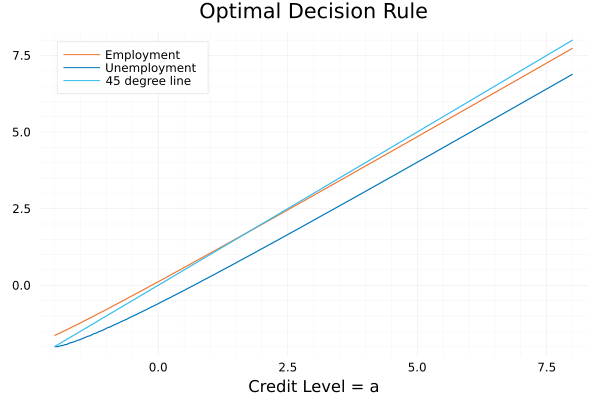

In [40]:
σ = 1.5
u(c) = c > 0. ? ((c) ^ (1 - σ)) / (1 - σ) : -Inf
q = risk_free_rate_1."Price (q)"[1]
Γ(a, e) = (a + e) / q
v1, v2, ah, al, as = VFI(u, Γ, tol, Nₚ, a_max, β, q, πs, eₕ, eₗ, a̲s[1])
theme(:vibrant)
plot(as, ah, label = "Employment")
plot!(as, al, label = "Unemployment")
plot!(as, as, label = "45 degree line", legend = :topleft, xlabel = "Credit Level = a", title = "Optimal Decision Rule")

## Figure 2

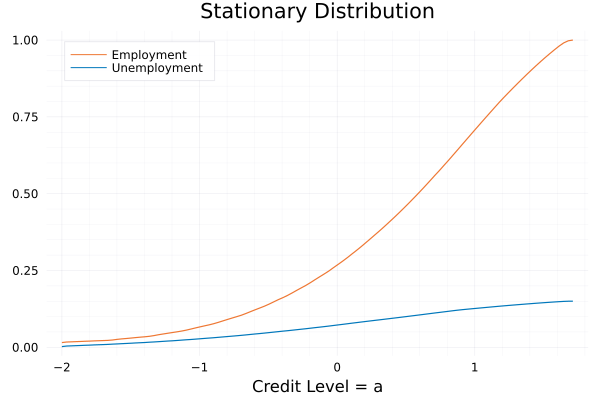

In [41]:
N = argmax(ah .> as) == argmin(ah .> as) ? Nₚ : argmin(ah .> as)
ψh, ψl = ψI(as, ah, al, N, a̲s[1], πs, tol*10^-1)
ψ_index = argmax(ψh)
plot(as[1:ψ_index], ψh[1:ψ_index], label = "Employment")
plot!(as[1:ψ_index], ψl[1:ψ_index], label = "Unemployment", legend = :topleft, xlabel = "Credit Level = a", title = "Stationary Distribution")